# Skin Disease Classification
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the **HAM10000 ("Human Against Machine with 10000 training images")** dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. 

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

<img src="https://image.ibb.co/n8PBkL/cover.png">

# Installing Libraries - Preparing the Environment

In [1]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')
    

Nvidia GPU detected!


In [2]:
from sys import platform
import subprocess

# if the platform is Mac OS X, install the nightly build of PyTorch
if platform == "darwin":
  print("Installing nightly build of PyTorch for Mac OS X")
  # %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
  subprocess.run(["pip", "install", "--pre", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/nightly/cpu"])
elif platform == "win32":
  print("Installing PyTorch for Windows")
  # %pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/cu117"])
# if the platform is Linux, install the nightly build of PyTorch
else:
  print("Installing PyTorch for Linux")
  try:
      subprocess.check_output('nvidia-smi')
      print('Nvidia GPU detected! Installing GPU version of PyTorch')
      subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/cu118"])
  except Exception: # this command not being found can raise quite a few different errors depending on the configuration
      print('No Nvidia GPU in system! Installing CPU-only version of PyTorch')
      subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio"])
  # %pip install torch torchvision torchaudio
  

Installing PyTorch for Windows


In [3]:
# %pip install pandas seaborn matplotlib numpy scikit-learn tensorflow keras
%pip install pandas seaborn matplotlib numpy scikit-learn humanize tensorboard torch_tb_profiler


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Step 1 : importing Libraries and Dataset

In [4]:
import sys
from torchvision.io import read_image
import torch
# from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import seaborn as sns
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(123)


#### Device Selection  - GPU or CPU or MPS

In [5]:
# Use GPU if it exists - for faster execution
# Device selection for PyTorch
device = torch.device("cpu")

# Device selection for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

device


Using GPU


device(type='cuda')

In [6]:
# 1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['acc'])+1),
                model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc'])+1),
                model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(
        1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1),
                model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1),
                model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(
        1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


Importing The Images and Labels

In [7]:
base_skin_dir = os.path.join('./', 'data')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]:
        x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [8]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df.sample(3)


lesion_id      image_id     dx    dx_type   age     sex  \
9725  HAM_0004376  ISIC_0024843  akiec      histo  70.0  female   
6059  HAM_0003024  ISIC_0024768     nv  follow_up  35.0  female   
4540  HAM_0001659  ISIC_0026564     nv  follow_up  35.0    male   

         localization                                            path  \
9725             face  ./data\HAM10000_images_part_1\ISIC_0024843.jpg   
6059            trunk  ./data\HAM10000_images_part_1\ISIC_0024768.jpg   
4540  lower extremity  ./data\HAM10000_images_part_1\ISIC_0026564.jpg   

              cell_type  
9725  Actinic keratoses  
6059   Melanocytic nevi  
4540   Melanocytic nevi

In [9]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                             path  \
0  ./data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ./data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ./data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ./data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ./data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  
0  Benign keratosis-like lesions   
1  Benign keratosis-like lesions   
2  Benign keratosis-like lesions   
3  Benign keratosis-like lesions   
4  Benign keratosis-like lesions

# Step 2 : Data Cleaning and EDA(Exploratory Data Analysis)
In this step we will be cleaning the data and doing some EDA(Exploratory Data Analysis) to get a better understanding of the data.

In [10]:
skin_df.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
cell_type        0
dtype: int64

Looks like age has some null values. We will be filling them with the mean of the age column.

In [11]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


Lets check the null values again, it should be 0 now.

In [12]:
skin_df.isnull().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
cell_type       0
dtype: int64

In [13]:
print(skin_df.dtypes)


lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
path             object
cell_type        object
dtype: object


Plotting a bar graph to see the distribution of the classes.

<Axes: >

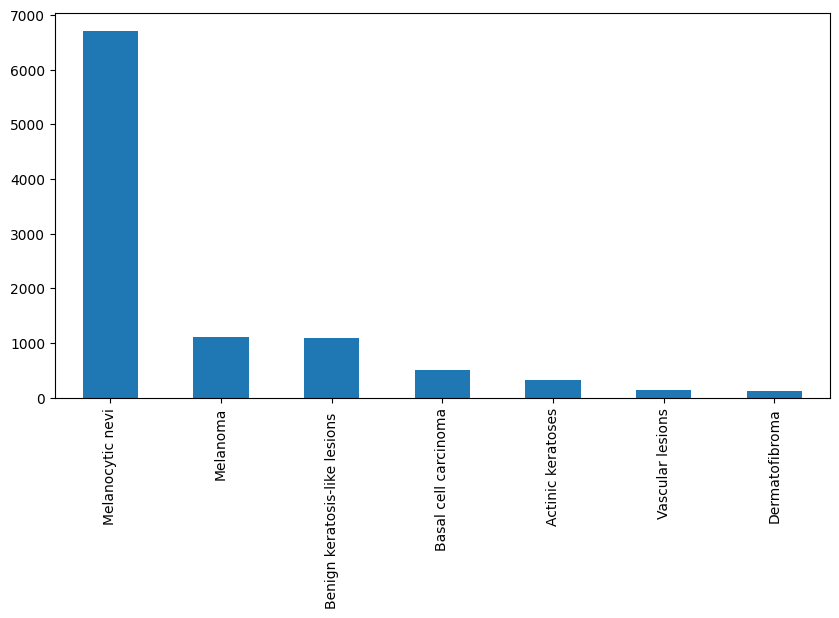

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


Plotting the distribution of localization field 

<Axes: >

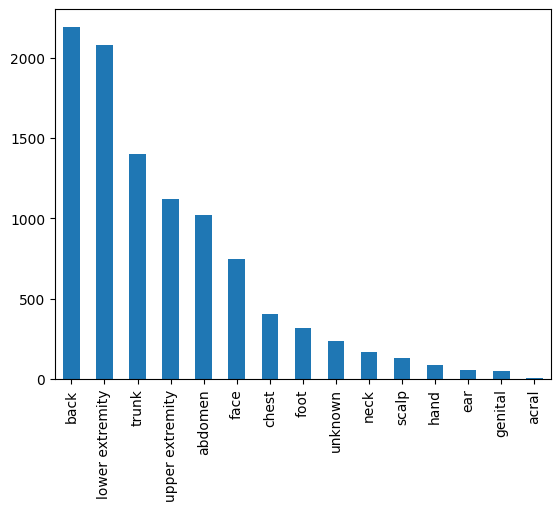

In [15]:
skin_df['localization'].value_counts().plot(kind='bar')


It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer 

Now, check the distribution of Age

<Axes: >

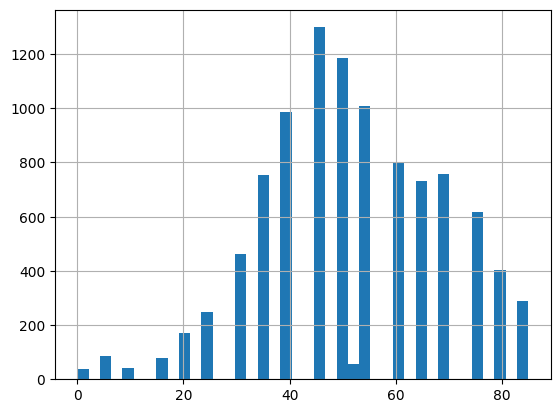

In [16]:
skin_df['age'].hist(bins=40)


It seems that there are larger instances of patients having age from 30 to 60

Lets see the distribution of males and females

<Axes: >

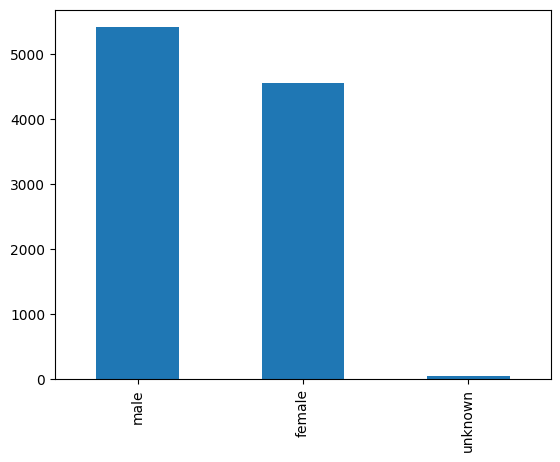

In [17]:

skin_df['sex'].value_counts().plot(kind='bar')


Sexwise distribution of skin cancer type

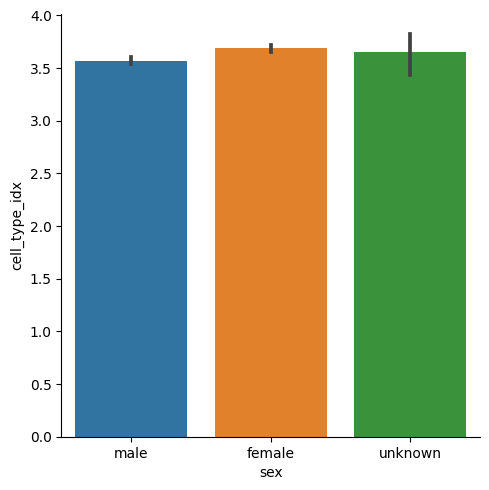

In [18]:
skin_df["cell_type_idx"] = pd.Categorical(skin_df['cell_type']).codes
sns.catplot(data=skin_df, x="sex", y="cell_type_idx", kind="bar")


# Step 3: Preprocessing the Images
In this step we will be preprocessing the images to make them ready for training.

In [19]:
# Load all the images into memory
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))


In [20]:
skin_df.head()


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                             path  \
0  ./data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ./data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ./data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ./data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ./data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

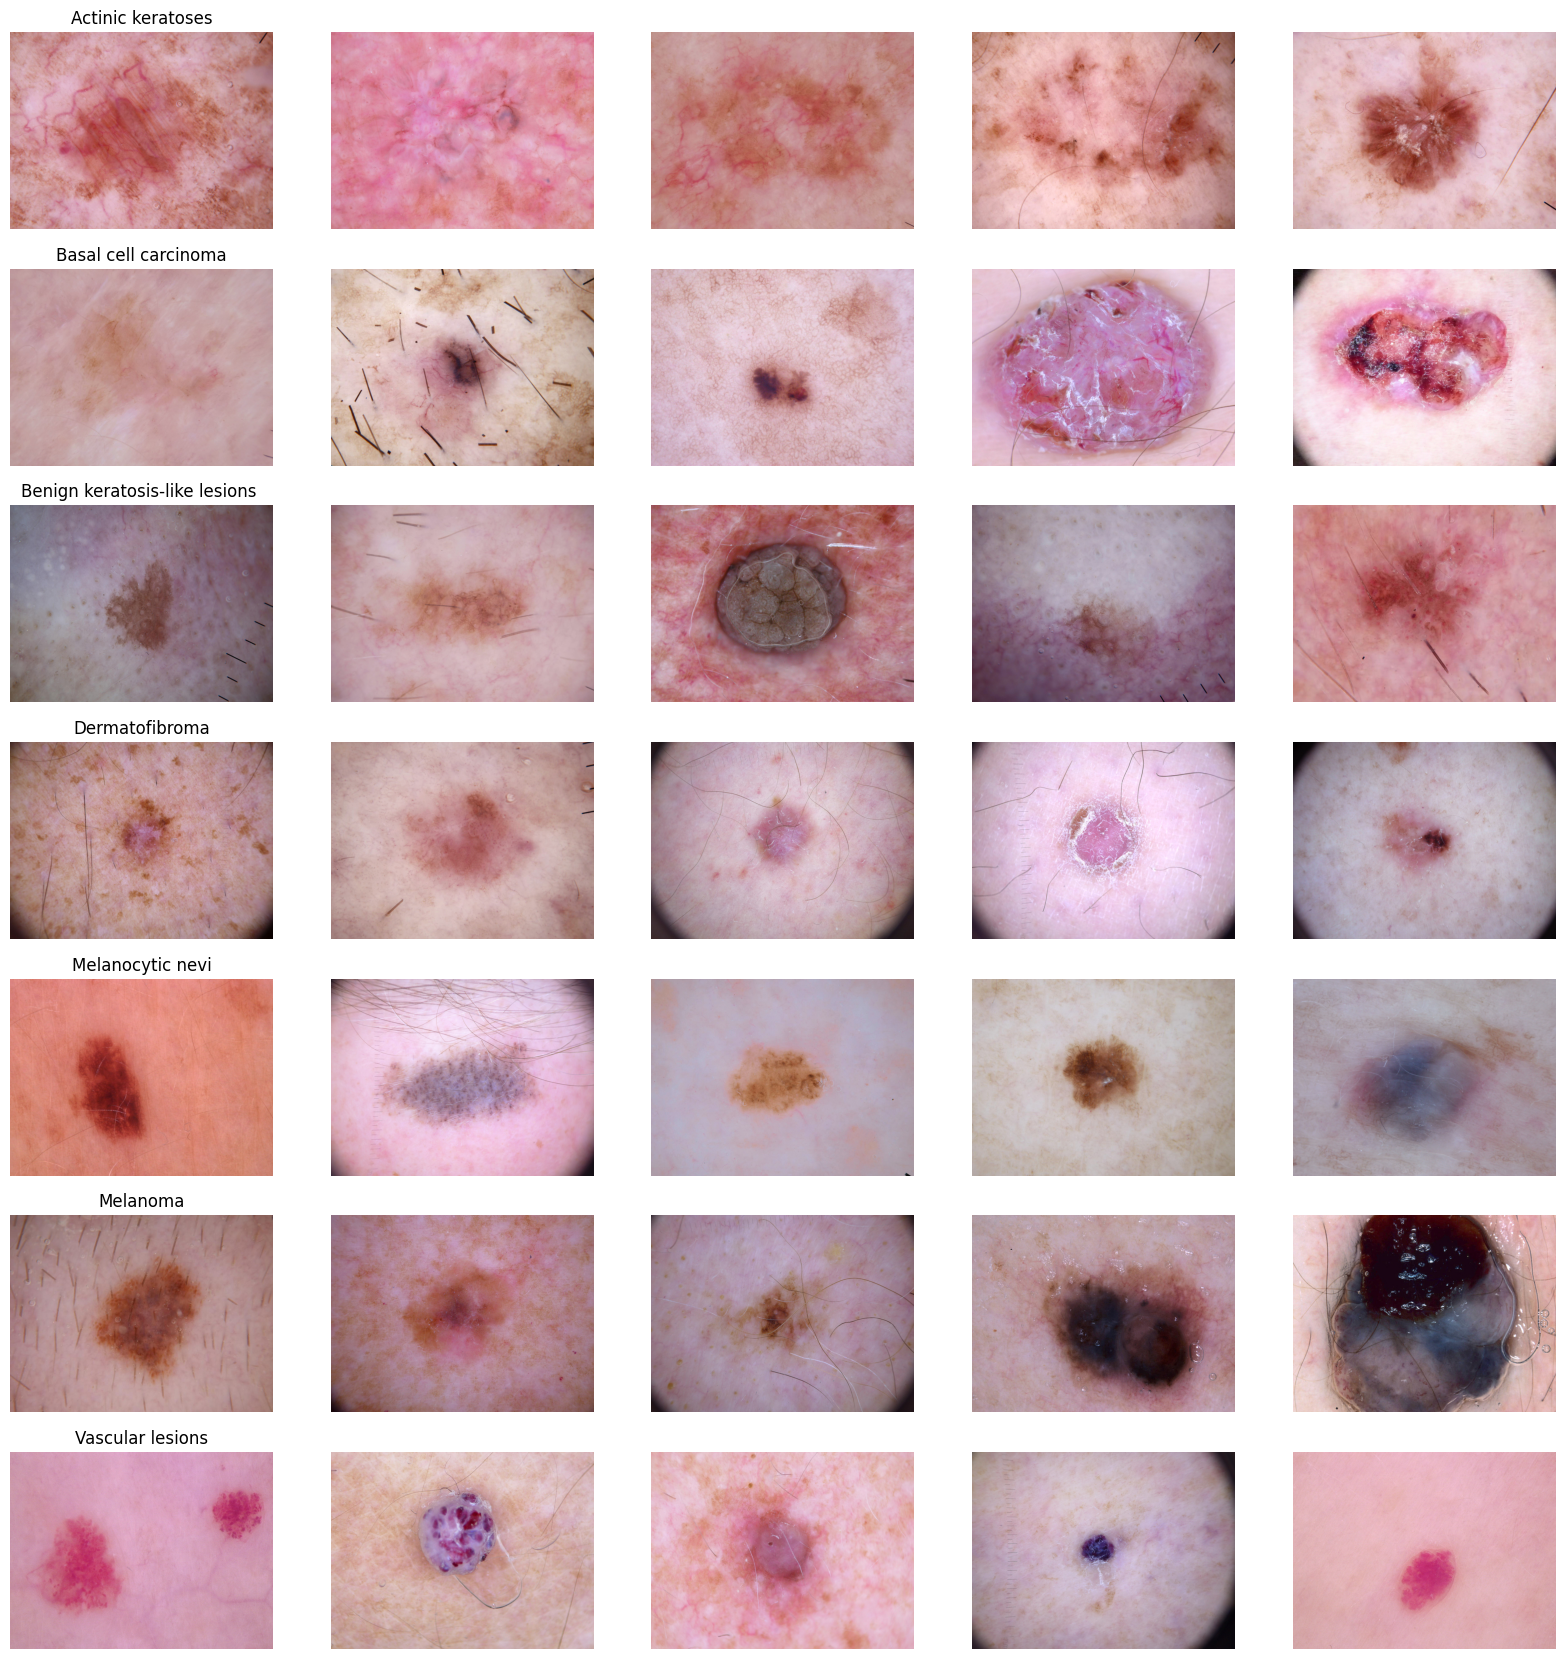

In [21]:
n_samples = 5


def openImage(x): return np.asarray(Image.open(x))


fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(openImage(c_row['path']))
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [22]:
# Checking the image size distribution
# skin_df['image'].map(lambda x: x.shape).value_counts()


In [23]:
skin_df.head()


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                             path  \
0  ./data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ./data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ./data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ./data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ./data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [24]:
# X -> age	sex	localization path
# y -> dx
# FIXME: Add more features like "age", "sex", "localization", now they will be ignored since we focus on building a model for the first time
model_dataset = skin_df[["dx", "path"]]
# rename dx to label
model_dataset = model_dataset.rename(columns={"dx": "label"})
model_dataset.head()


label                                            path
0   bkl  ./data\HAM10000_images_part_1\ISIC_0027419.jpg
1   bkl  ./data\HAM10000_images_part_1\ISIC_0025030.jpg
2   bkl  ./data\HAM10000_images_part_1\ISIC_0026769.jpg
3   bkl  ./data\HAM10000_images_part_1\ISIC_0025661.jpg
4   bkl  ./data\HAM10000_images_part_2\ISIC_0031633.jpg

### Normalization
Normalization is done by subtracting the mean and dividing by the standard deviation of the pixel values. This is done so that the mean of the pixel values is 0 and the standard deviation is 1. This is done so that the model does not get biased towards any particular pixel value.

In [25]:
# FIXME: we will implement this later, for now we will use the whole dataset as it is

# x_train_small = x_train_o.sample(n=10, random_state=1234)
# x_train = np.asarray(x_train_small['image'].tolist())
# # x_test = np.asarray(x_test_o['image'].tolist())

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# # x_test_mean = np.mean(x_test)
# # x_test_std = np.std(x_test)

# x_train = (x_train - x_train_mean)/x_train_std
# # x_test = (x_test - x_test_mean)/x_test_std

# print(f"Mean of x_train: {x_train_mean}")
# print(f"Std of x_train: {x_train_std}")


In [26]:
# finding the mean and standard deviation of all the images without loading them into memory

# img_mean = 0.
# img_std = 0.

# for image in skin_df['path']:
#     img = openImage(image)
#     img_mean += img.mean()
#     img_std += img.std()

# img_mean /= len(skin_df['path'])
# img_std /= len(skin_df['path'])

# print(f"Mean: {img_mean}, Std: {img_std}")


### Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [27]:
# Perform one-hot encoding on the labels
# y_train = to_categorical(y_train_o, num_classes = 7)
# y_test = to_categorical(y_test_o, num_classes = 7)

# Create a map of labels and their one hot encodings from y.unique()
label_map = {"nv": 0, "mel": 1, "bkl": 2,
             "bcc": 3, "akiec": 4, "vasc": 5, "df": 6}


class MyLabelEncoder():
    def __init__(self, label_map):
        self.label_map = label_map
        self.label_map_inv = {v: k for k, v in label_map.items()}

    def encode(self, label):
        return self.label_map[label]

    def decode(self, key):
        return self.label_map_inv[key]


label_encoder = MyLabelEncoder(label_map)


### Data Loader

In [28]:
# Get Max Memory Available
import psutil
import humanize
import sys


class MemoryCache():
    # static variable for holding the instance reference
    __instances = {}

    # to string method
    def __str__(self):
        return f"Max Memory: {self.max_memory}, Current Memory: {self.get_size()}"

    # static method for getings instance
    @staticmethod
    def getInstance(max_memory=None, usable_memory_percentage=0.6, DEBUG=False, value_size_getter=None):
        # check if instance witg the same parameters already exists
        key = (max_memory, usable_memory_percentage, DEBUG, value_size_getter)
        if key not in MemoryCache.__instances:
            # if not, create a new instance
            MemoryCache.__instances[key] = MemoryCache(
                max_memory, usable_memory_percentage, DEBUG, value_size_getter)
        # return the instance
        return MemoryCache.__instances[key]

    def print(self, *args, **kwargs):
        if self.DEBUG:
            print(*args, **kwargs)

    def __init__(self, max_memory=None, usable_memory_percentage=0.6, DEBUG=False, value_size_getter=None):
        self.DEBUG = DEBUG
        self.print("Initializing Memory Cache")

        self.value_size_getter = value_size_getter

        if max_memory is None:
            mem = psutil.virtual_memory()
            # Get the max memory available for the images
            max_memory = mem.available * usable_memory_percentage
        self.print(f"Max Memory: {max_memory/1000000:.2f} MB")
        self.max_memory = max_memory
        self.img_cache = {}

        self.print("Memory Cache Initialized")

        self.print(f"Max Memory: {humanize.naturalsize(self.max_memory)}")

    def get_size(self):
        size = 0
        for key in self.img_cache:
            size += sys.getsizeof(key)
            if self.value_size_getter is not None:
                size += self.value_size_getter(self.img_cache[key])
            else:
                size += sys.getsizeof(self.img_cache[key])
        self.print(
            f"Current Memory Used: {humanize.naturalsize(size)}, Max Memory: {humanize.naturalsize(self.max_memory)}, Memory Used: {size/self.max_memory*100:.3f}%")
        return size

    def can_fit_in_memory(self):
        obj_size = self.get_size()
        return obj_size < self.max_memory

    def set(self, key, cache):
        cache_size = None
        if self.value_size_getter is not None:
            cache_size = self.value_size_getter(cache)
        else:
            cache_size = sys.getsizeof(cache)

        if self.can_fit_in_memory():
            self.img_cache[key] = cache
        else:
            self.print("Not enough memory to cache the image")

        memory_used = self.get_size() / self.max_memory * 100
        self.print(
            f'Data size: {humanize.naturalsize(cache_size)} - Cache size: {humanize.naturalsize(self.get_size())} - Memory Used: {memory_used:.3f}% - Entries: {len(self.img_cache)}')

    def get(self, key):
        if key in self.img_cache:
            return self.img_cache[key]
        else:
            return None

    def exists(self, key):
        return key in self.img_cache


In [29]:
# Create the dataset for DataLoader

torch.manual_seed(17)


class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, target_transform=None,
                 max_cache_memory_available=None, usable_cache_memory_percentage=0.6):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        # Since x is a tensor, we need to use the storage() method to get the size of the tensor
        def value_size_getter(x): return sys.getsizeof(x.untyped_storage())
        self.memory_cache = MemoryCache.getInstance(max_memory=max_cache_memory_available,  usable_memory_percentage=usable_cache_memory_percentage,
                                                    value_size_getter=value_size_getter, DEBUG=False)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        label = self.dataset[idx].label
        img_path = self.dataset[idx].path

        image = None
        if self.memory_cache.exists(img_path):
            image = self.memory_cache.get(img_path)
            # print("Image already in memory")
        else:
            image = read_image(img_path)
            self.memory_cache.set(img_path, image)

        # Image transformation
        if self.transform:
            image = self.transform(image)

        # Label transformation
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


### Data Transformer

In [30]:
# Transformer
from torchvision import transforms as T

image_size = 224
# Define the transforms
transformer = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    # T.Normalize((0.5,), (0.5,))
])

# GPU transformation
transformer_gpu = torch.nn.Sequential(
    # resize the image to the required size
    T.Resize((image_size, image_size)),
    # convert to FloatTensor
    T.ConvertImageDtype(torch.float),
)


### Testing our transformer!

d:\projects\venvs\pytorch-ml\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


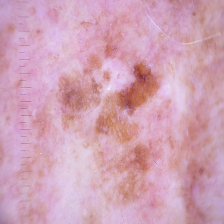

torch.cuda.FloatTensor


In [31]:
# Testing the transformer
my_image = read_image(model_dataset["path"][0])
my_image = my_image.to(device)
tensor = transformer_gpu(my_image)
transformedImage = T.ToPILImage()(tensor)
display(transformedImage)
print(tensor.type())

### Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [32]:
# split the DataFrame into training and testing subsets
model_dataset_list = model_dataset.values.tolist()


class ImageLabelData():
    def __init__(self, path, label):
        self.path = path
        self.label = label


# for testing purposes, we will use a smaller dataset
# model_dataset_list = model_dataset_list[:1000]

model_dataset_list = [ImageLabelData(path, label)
                      for label, path in model_dataset_list]

train_df, test_df = train_test_split(
    model_dataset_list, test_size=0.2, random_state=42)


In [33]:
from torch.utils.data import DataLoader

batch_size = 256

# transformer_lambda = lambda x: transformer(x.to(device))

def transformer_lambda(x):
    transoformed = transformer_gpu(x.to(device))
    return transoformed


train_dataset = CustomImageDataset(dataset=train_df, transform=transformer_lambda,
                                   target_transform=label_encoder.encode, usable_cache_memory_percentage=0.6)
train_dl = DataLoader(train_dataset, batch_size,
                      shuffle=True, num_workers=0, pin_memory=False)

validation_dataset = CustomImageDataset(dataset=test_df, transform=transformer_lambda,
                                        target_transform=label_encoder.encode, usable_cache_memory_percentage=0.6)
validation_dl = DataLoader(
    validation_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)


tensor([[[0.9529, 0.9647, 0.9686,  ..., 0.9686, 0.9686, 0.9647],
         [0.9647, 0.9686, 0.9608,  ..., 0.9725, 0.9725, 0.9725],
         [0.9725, 0.9725, 0.9765,  ..., 0.9686, 0.9608, 0.9686],
         ...,
         [0.9059, 0.9059, 0.9059,  ..., 0.8941, 0.8902, 0.8863],
         [0.9098, 0.9137, 0.9137,  ..., 0.9020, 0.8902, 0.8863],
         [0.9098, 0.9020, 0.9137,  ..., 0.8980, 0.8941, 0.8941]],

        [[0.6667, 0.6863, 0.6824,  ..., 0.7216, 0.7137, 0.7176],
         [0.6784, 0.6863, 0.6784,  ..., 0.7255, 0.7176, 0.7059],
         [0.6902, 0.6941, 0.6941,  ..., 0.7216, 0.7137, 0.7137],
         ...,
         [0.6588, 0.6627, 0.6627,  ..., 0.6549, 0.6510, 0.6510],
         [0.6706, 0.6627, 0.6627,  ..., 0.6510, 0.6549, 0.6510],
         [0.6627, 0.6471, 0.6588,  ..., 0.6588, 0.6549, 0.6549]],

        [[0.7412, 0.7490, 0.7569,  ..., 0.7765, 0.7725, 0.7765],
         [0.7373, 0.7529, 0.7529,  ..., 0.7804, 0.7843, 0.7725],
         [0.7569, 0.7529, 0.7686,  ..., 0.7725, 0.7647, 0.

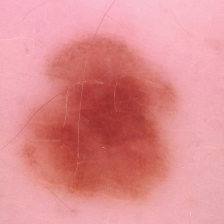

In [34]:
# lets access the first batch
for data, label in train_dl:
    print(data[0], label[0])
    image = T.ToPILImage()(data[0])
    display(image)
    break


# Step 4: Model Building 
### CNN

In [35]:
import torch.nn as nn

# # Set the CNN model
# # CNN architecture -> [[Conv2d->relu]*2 -> MaxPool2d -> Dropout]*2 -> Flatten -> Linear -> Dropout -> Out


# class CNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CNN, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32,
#                       kernel_size=(3, 3), padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=32, out_channels=32,
#                       kernel_size=(3, 3), padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2)),
#             nn.Dropout(p=0.25)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64,
#                       kernel_size=(3, 3), padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=64,
#                       kernel_size=(3, 3), padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2)),
#             nn.Dropout(p=0.4)
#         )

#         self.flatten = nn.Flatten()
#         # self.fc1 = nn.Linear(64*18*25, 128)
#         # Shape after flatten:  torch.Size([128, 200704])
#         # Expected shape:  (28800, 128)

#         self.fc1 = nn.Linear(200704, 128)
#         self.relu5 = nn.ReLU()
#         self.dropout3 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.layer1(x)

#         x = self.layer2(x)

#         x = self.flatten(x)
#         # print("Shape after flatten: ", x.shape)
#         # print("Expected shape: ", (64*18*25, 128))
#         x = self.fc1(x)
#         x = self.relu5(x)
#         x = self.dropout3(x)
#         x = self.fc2(x)
#         return x


In [36]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,num_classes)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [37]:

model = CNN(7)
model = model.to(device)

### Setting Optimizer and Annealer

In [38]:
from torch import optim
# Define the optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(
    0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Define the loss function
criterion = nn.CrossEntropyLoss()


In [39]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set a learning rate annealer
scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=0.00001)


### Writing the model to tensorboard for visualization

In [40]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("logs/runs")
examples = iter(train_dl)
example_data, example_targets = next(examples)
example_data = example_data.to(device)
writer.add_graph(model, example_data)

In [41]:
total_epochs = 200
epoch = 0

In [42]:
import time
from tqdm import tqdm
from torch.profiler import profile, record_function, ProfilerActivity

def sleep_with_progress_bar(sleep_time):
    for _ in tqdm(range(sleep_time), desc="Sleeping", unit="s"):
        time.sleep(1)

# ------PROFILING------
ENABLE_PROFILING = False
prof = profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
               schedule=torch.profiler.schedule(
    wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(
    './logs/runs'),
    record_shapes=True,
    with_stack=True
)
# ------PROFILING------

train_losses = []
train_accs = []
val_losses = []
val_accs = []


def train(model, train_loader, optimizer, criterion, device, train_on_gpu=False):
    model.train()
    train_loss = 0
    train_acc = 0
    n_total_steps = len(train_loader)
    for data, target in tqdm(train_loader, desc="Training", unit="batch"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        # break

        train_loss += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()

        # Check accuracy
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(
            correct_tensor.cpu().numpy())
        train_acc += np.sum(correct)
        if ENABLE_PROFILING:
            prof.step()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    ############## TENSORBOARD ########################
    writer.add_scalar('training loss', train_loss)
    writer.add_scalar('accuracy', train_acc)
    ###################################################
    return train_loss, train_acc


# when device is cpu, train_on_gpu = False
train_on_gpu = False if device == "cpu" else True

# lets test the train function
# train_loss, train_acc = train(model, train_dl, optimizer, criterion, device=device, train_on_gpu = train_on_gpu)
# print("Train Loss: {:.6f}, Train Acc: {:.6f}".format(train_loss, train_acc))


def validate(model, val_loader, criterion, device, train_on_gpu=False):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validating", unit="batch"):
            with record_function("load input batch"):
                data, target = data.to(device), target.to(device)
            with record_function("Training step"):
                output = model(data)
                loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            # Check accuracy
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(
                correct_tensor.cpu().numpy())
            val_acc += np.sum(correct)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    return val_loss, val_acc

# lets test the validate function
# val_loss, val_acc = validate(model, validation_dl, criterion, device=device, train_on_gpu = train_on_gpu)

# print("Val Loss: {:.6f}, Val Acc: {:.6f}".format(val_loss, val_acc))

if ENABLE_PROFILING:
    prof.start()
for i in range(total_epochs):
    if epoch > i:
        print("Skipping epoch {}".format(i))
        continue
    # ------- BREAK FOR GPU COOLING DOWN -------
    BREAK_EVERY = 20
    SLEEP_FOR = 60
    if epoch % BREAK_EVERY == 0 and epoch != 0:
        print("Break for {} seconds".format(SLEEP_FOR))
        sleep_with_progress_bar(SLEEP_FOR)
    # ------- BREAK FOR GPU COOLING DOWN -------
    print("Epoch: {}/{}".format(epoch+1, total_epochs))
    print("-"*10, "Training", "-"*10)
    with record_function("training_function"):
        train_loss, train_acc = train(
            model, train_dl, optimizer, criterion, device=device, train_on_gpu=train_on_gpu)
    print("Train Loss: {:.6f}, Train Acc: {:.6f}".format(
        train_loss, train_acc))
    print("-"*10, "Validation", "-"*10)
    val_loss, val_acc = validate(
        model, validation_dl, criterion, device=device, train_on_gpu=train_on_gpu)

    print("Val Loss: {:.6f}, Val Acc: {:.6f}".format(val_loss, val_acc))
    scheduler.step(val_acc)

    # Save the losses and accuracies
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print("-"*10, "End of Epoch", "-"*10)
    epoch += 1
    # profiler results
if ENABLE_PROFILING:
    prof.stop()
# prof.export_chrome_trace("cpu_profiling_results.json")

Epoch: 1/200
---------- Training ----------


Training: 100%|██████████| 32/32 [03:01<00:00,  5.66s/batch]


Train Loss: 1.862734, Train Acc: 0.039940
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:24<00:00,  3.09s/batch]


Val Loss: 1.821053, Val Acc: 0.052421
---------- End of Epoch ----------
Epoch: 2/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.24batch/s]


Train Loss: 1.585709, Train Acc: 0.260609
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.21batch/s]


Val Loss: 1.327838, Val Acc: 0.637544
---------- End of Epoch ----------
Epoch: 3/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.38batch/s]


Train Loss: 1.129759, Train Acc: 0.672366
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.17batch/s]


Val Loss: 1.085439, Val Acc: 0.676985
---------- End of Epoch ----------
Epoch: 4/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.16batch/s]


Train Loss: 1.006981, Train Acc: 0.673864
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.21batch/s]


Val Loss: 1.034211, Val Acc: 0.668997
---------- End of Epoch ----------
Epoch: 5/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.39batch/s]


Train Loss: 0.939547, Train Acc: 0.679356
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.80batch/s]


Val Loss: 1.043685, Val Acc: 0.668997
---------- End of Epoch ----------
Epoch: 6/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.57batch/s]


Train Loss: 0.884910, Train Acc: 0.684348
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.91batch/s]


Val Loss: 0.907257, Val Acc: 0.672491
---------- End of Epoch ----------
Epoch: 7/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.36batch/s]


Train Loss: 0.846738, Train Acc: 0.686221
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.66batch/s]


Val Loss: 0.881724, Val Acc: 0.676985
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
---------- End of Epoch ----------
Epoch: 8/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.29batch/s]


Train Loss: 0.815647, Train Acc: 0.689840
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.16batch/s]


Val Loss: 0.838686, Val Acc: 0.684973
---------- End of Epoch ----------
Epoch: 9/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.21batch/s]


Train Loss: 0.797328, Train Acc: 0.693959
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.91batch/s]


Val Loss: 0.861517, Val Acc: 0.681977
---------- End of Epoch ----------
Epoch: 10/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.26batch/s]


Train Loss: 0.782541, Train Acc: 0.695956
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.07batch/s]


Val Loss: 0.822069, Val Acc: 0.688967
---------- End of Epoch ----------
Epoch: 11/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.38batch/s]


Train Loss: 0.767931, Train Acc: 0.701198
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.40batch/s]


Val Loss: 0.806233, Val Acc: 0.687968
---------- End of Epoch ----------
Epoch: 12/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.20batch/s]


Train Loss: 0.755283, Train Acc: 0.700949
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.41batch/s]


Val Loss: 0.819489, Val Acc: 0.692461
---------- End of Epoch ----------
Epoch: 13/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.34batch/s]


Train Loss: 0.739895, Train Acc: 0.704693
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.43batch/s]


Val Loss: 0.814689, Val Acc: 0.692461
---------- End of Epoch ----------
Epoch: 14/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.38batch/s]


Train Loss: 0.722074, Train Acc: 0.714803
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.32batch/s]


Val Loss: 0.798557, Val Acc: 0.685971
---------- End of Epoch ----------
Epoch: 15/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.43batch/s]


Train Loss: 0.707934, Train Acc: 0.717923
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.26batch/s]


Val Loss: 0.830698, Val Acc: 0.691463
---------- End of Epoch ----------
Epoch: 16/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.22batch/s]


Train Loss: 0.695612, Train Acc: 0.726410
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.05batch/s]


Val Loss: 0.781549, Val Acc: 0.703944
---------- End of Epoch ----------
Epoch: 17/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.32batch/s]


Train Loss: 0.685155, Train Acc: 0.737644
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.47batch/s]


Val Loss: 0.775201, Val Acc: 0.704443
---------- End of Epoch ----------
Epoch: 18/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.45batch/s]


Train Loss: 0.672634, Train Acc: 0.743884
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.34batch/s]


Val Loss: 0.771548, Val Acc: 0.714428
---------- End of Epoch ----------
Epoch: 19/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.42batch/s]


Train Loss: 0.664790, Train Acc: 0.752496
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.78batch/s]


Val Loss: 0.804306, Val Acc: 0.713430
---------- End of Epoch ----------
Epoch: 20/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.24batch/s]


Train Loss: 0.650423, Train Acc: 0.756241
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.48batch/s]


Val Loss: 0.764757, Val Acc: 0.729905
---------- End of Epoch ----------
Break for 60 seconds


Sleeping: 100%|██████████| 60/60 [01:00<00:00,  1.01s/s]


Epoch: 21/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.01batch/s]


Train Loss: 0.641783, Train Acc: 0.765602
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.83batch/s]


Val Loss: 0.762990, Val Acc: 0.727409
---------- End of Epoch ----------
Epoch: 22/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.33batch/s]


Train Loss: 0.623477, Train Acc: 0.769471
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.12batch/s]


Val Loss: 0.759225, Val Acc: 0.731902
---------- End of Epoch ----------
Epoch: 23/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.44batch/s]


Train Loss: 0.611901, Train Acc: 0.777584
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.78batch/s]


Val Loss: 0.747603, Val Acc: 0.729905
---------- End of Epoch ----------
Epoch: 24/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.27batch/s]


Train Loss: 0.613093, Train Acc: 0.780330
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.06batch/s]


Val Loss: 0.845574, Val Acc: 0.717424
---------- End of Epoch ----------
Epoch: 25/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.34batch/s]


Train Loss: 0.594519, Train Acc: 0.788817
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.01batch/s]


Val Loss: 0.728701, Val Acc: 0.738392
---------- End of Epoch ----------
Epoch: 26/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.15batch/s]


Train Loss: 0.589284, Train Acc: 0.786695
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.13batch/s]


Val Loss: 0.747655, Val Acc: 0.734898
---------- End of Epoch ----------
Epoch: 27/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.35batch/s]


Train Loss: 0.567147, Train Acc: 0.796930
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.16batch/s]


Val Loss: 0.765620, Val Acc: 0.720919
---------- End of Epoch ----------
Epoch: 28/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.32batch/s]


Train Loss: 0.561631, Train Acc: 0.798677
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.17batch/s]


Val Loss: 0.745772, Val Acc: 0.722416
---------- End of Epoch ----------
Epoch: 29/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.30batch/s]


Train Loss: 0.549769, Train Acc: 0.802421
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.01batch/s]


Val Loss: 0.741539, Val Acc: 0.723914
Epoch 00029: reducing learning rate of group 0 to 2.5000e-04.
---------- End of Epoch ----------
Epoch: 30/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.34batch/s]


Train Loss: 0.534755, Train Acc: 0.808288
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.29batch/s]


Val Loss: 0.717920, Val Acc: 0.736395
---------- End of Epoch ----------
Epoch: 31/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.16batch/s]


Train Loss: 0.522472, Train Acc: 0.815027
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.86batch/s]


Val Loss: 0.728454, Val Acc: 0.737394
---------- End of Epoch ----------
Epoch: 32/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.24batch/s]


Train Loss: 0.514962, Train Acc: 0.820769
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.71batch/s]


Val Loss: 0.703328, Val Acc: 0.743385
---------- End of Epoch ----------
Epoch: 33/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.25batch/s]


Train Loss: 0.513399, Train Acc: 0.814403
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.13batch/s]


Val Loss: 0.706956, Val Acc: 0.746880
---------- End of Epoch ----------
Epoch: 34/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.38batch/s]


Train Loss: 0.499949, Train Acc: 0.824638
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.95batch/s]


Val Loss: 0.708741, Val Acc: 0.748877
---------- End of Epoch ----------
Epoch: 35/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.36batch/s]


Train Loss: 0.499639, Train Acc: 0.825137
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.87batch/s]


Val Loss: 0.738532, Val Acc: 0.736395
---------- End of Epoch ----------
Epoch: 36/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.31batch/s]


Train Loss: 0.493872, Train Acc: 0.829631
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.01batch/s]


Val Loss: 0.734234, Val Acc: 0.741388
---------- End of Epoch ----------
Epoch: 37/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.41batch/s]


Train Loss: 0.479020, Train Acc: 0.833250
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.06batch/s]


Val Loss: 0.720433, Val Acc: 0.746880
---------- End of Epoch ----------
Epoch: 38/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.18batch/s]


Train Loss: 0.479665, Train Acc: 0.832626
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.10batch/s]


Val Loss: 0.714852, Val Acc: 0.747379
Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.
---------- End of Epoch ----------
Epoch: 39/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.33batch/s]


Train Loss: 0.468526, Train Acc: 0.842611
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.33batch/s]


Val Loss: 0.715102, Val Acc: 0.745382
---------- End of Epoch ----------
Epoch: 40/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.29batch/s]


Train Loss: 0.460409, Train Acc: 0.843859
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.04batch/s]


Val Loss: 0.723103, Val Acc: 0.744383
---------- End of Epoch ----------
Break for 60 seconds


Sleeping: 100%|██████████| 60/60 [01:00<00:00,  1.01s/s]


Epoch: 41/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  6.78batch/s]


Train Loss: 0.455512, Train Acc: 0.845731
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.98batch/s]


Val Loss: 0.711223, Val Acc: 0.742886
---------- End of Epoch ----------
Epoch: 42/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.44batch/s]


Train Loss: 0.454924, Train Acc: 0.843610
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.04batch/s]


Val Loss: 0.726994, Val Acc: 0.750374
---------- End of Epoch ----------
Epoch: 43/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.36batch/s]


Train Loss: 0.449335, Train Acc: 0.845981
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.63batch/s]


Val Loss: 0.708510, Val Acc: 0.749376
---------- End of Epoch ----------
Epoch: 44/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.35batch/s]


Train Loss: 0.444852, Train Acc: 0.852846
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.11batch/s]


Val Loss: 0.717303, Val Acc: 0.749875
---------- End of Epoch ----------
Epoch: 45/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.30batch/s]


Train Loss: 0.442954, Train Acc: 0.853844
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.06batch/s]


Val Loss: 0.722292, Val Acc: 0.744383
---------- End of Epoch ----------
Epoch: 46/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.47batch/s]


Train Loss: 0.439223, Train Acc: 0.855592
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.11batch/s]


Val Loss: 0.716405, Val Acc: 0.748877
Epoch 00046: reducing learning rate of group 0 to 6.2500e-05.
---------- End of Epoch ----------
Epoch: 47/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.52batch/s]


Train Loss: 0.435322, Train Acc: 0.856216
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.12batch/s]


Val Loss: 0.719472, Val Acc: 0.749875
---------- End of Epoch ----------
Epoch: 48/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.26batch/s]


Train Loss: 0.431957, Train Acc: 0.857589
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.84batch/s]


Val Loss: 0.716875, Val Acc: 0.752371
---------- End of Epoch ----------
Epoch: 49/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.34batch/s]


Train Loss: 0.429053, Train Acc: 0.859835
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.91batch/s]


Val Loss: 0.717217, Val Acc: 0.750374
---------- End of Epoch ----------
Epoch: 50/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.11batch/s]


Train Loss: 0.428840, Train Acc: 0.858712
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.77batch/s]


Val Loss: 0.715195, Val Acc: 0.749875
---------- End of Epoch ----------
Epoch: 51/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.33batch/s]


Train Loss: 0.426715, Train Acc: 0.859461
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.79batch/s]


Val Loss: 0.717636, Val Acc: 0.749875
---------- End of Epoch ----------
Epoch: 52/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.20batch/s]


Train Loss: 0.424617, Train Acc: 0.859336
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.75batch/s]


Val Loss: 0.713771, Val Acc: 0.750874
Epoch 00052: reducing learning rate of group 0 to 3.1250e-05.
---------- End of Epoch ----------
Epoch: 53/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.30batch/s]


Train Loss: 0.421901, Train Acc: 0.862207
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.05batch/s]


Val Loss: 0.712733, Val Acc: 0.752371
---------- End of Epoch ----------
Epoch: 54/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.27batch/s]


Train Loss: 0.419907, Train Acc: 0.862082
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.01batch/s]


Val Loss: 0.715327, Val Acc: 0.748877
---------- End of Epoch ----------
Epoch: 55/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.57batch/s]


Train Loss: 0.420732, Train Acc: 0.862456
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.75batch/s]


Val Loss: 0.718334, Val Acc: 0.749875
---------- End of Epoch ----------
Epoch: 56/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.30batch/s]


Train Loss: 0.419152, Train Acc: 0.862207
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.79batch/s]


Val Loss: 0.715679, Val Acc: 0.753370
---------- End of Epoch ----------
Epoch: 57/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.38batch/s]


Train Loss: 0.418943, Train Acc: 0.863080
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.08batch/s]


Val Loss: 0.715331, Val Acc: 0.752371
---------- End of Epoch ----------
Epoch: 58/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.24batch/s]


Train Loss: 0.417075, Train Acc: 0.864329
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.98batch/s]


Val Loss: 0.721355, Val Acc: 0.750374
---------- End of Epoch ----------
Epoch: 59/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.14batch/s]


Train Loss: 0.415805, Train Acc: 0.865202
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:00<00:00,  8.22batch/s]


Val Loss: 0.716196, Val Acc: 0.751373
---------- End of Epoch ----------
Epoch: 60/200
---------- Training ----------


Training: 100%|██████████| 32/32 [00:04<00:00,  7.35batch/s]


Train Loss: 0.414016, Train Acc: 0.862706
---------- Validation ----------


Validating: 100%|██████████| 8/8 [00:01<00:00,  7.46batch/s]


Val Loss: 0.716576, Val Acc: 0.749875
Epoch 00060: reducing learning rate of group 0 to 1.5625e-05.
---------- End of Epoch ----------
Break for 60 seconds


Sleeping:   8%|▊         | 5/60 [00:06<01:06,  1.21s/s]


KeyboardInterrupt: 

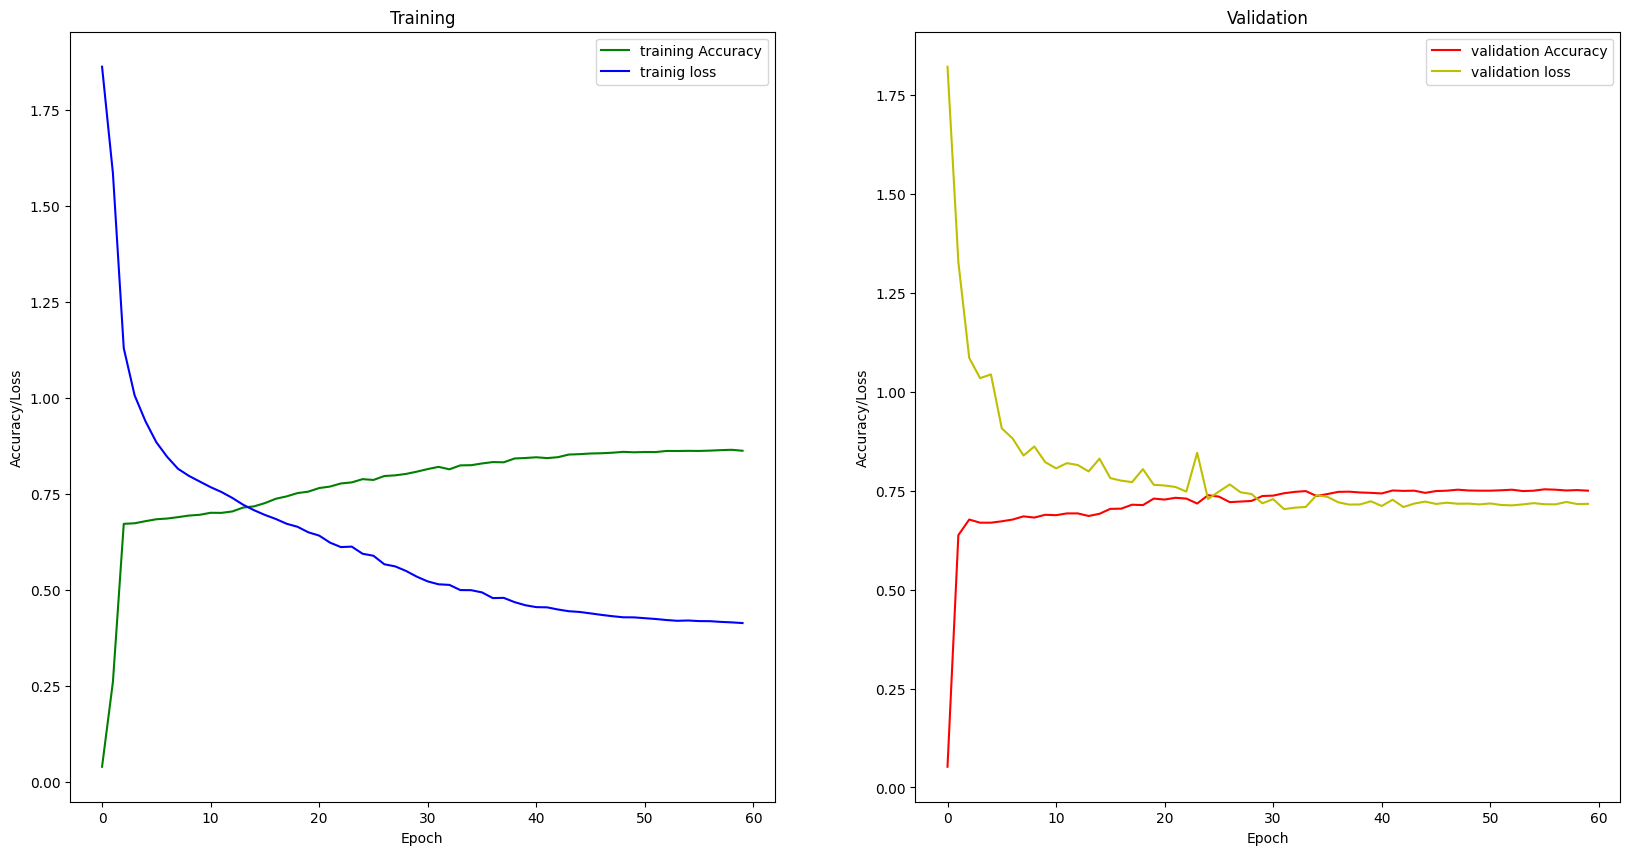

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []

train_acc_loss = list(zip(train_accs, train_losses))
val_acc_loss = list(zip(val_accs, val_losses))

# Create a plot for accuracy against each epoch
fig, (ax1, ax2) = plt.subplots(nrows=1,
                                        ncols=2,
                                        figsize=(20, 10))
# Training -----
# Train Accuracy per epoch
y = [acc for acc, loss in train_acc_loss]
x = np.arange(len(y))
ax1.plot(x, y, color='g', label='training Accuracy')


# Train Loss per epoch
y = [loss for acc, loss in train_acc_loss]
ax1.plot(x, y, color='b', label='trainig loss')


# Validation -----
# Validation Accuracy per epoch
y = [acc for acc, loss in val_acc_loss]
ax2.plot(x, y, color='r', label='validation Accuracy')

# Validation loss per epoch
y = [loss for acc, loss in val_acc_loss]
ax2.plot(x, y, color='y', label='validation loss')

ax1.set(title="Training", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

ax2.set(title="Validation", 
      ylabel="Accuracy/Loss", xlabel="Epoch");

# Adding legend, which helps us recognize the curve according to it's color
ax1.legend();
ax2.legend(); 

In [44]:
# Convert the model to CPU and save it
model.to("cpu")
torch.save(model.state_dict(), "model.pth")

# Inferencing

Things required for inferencing
* Model
* Transformer

In [3]:
import torch.nn as nn

# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,num_classes)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [4]:
import torch
model = CNN(num_classes=7)

# Load the model state dict
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [16]:
# import image
from torchvision import transforms
from torchvision.io import read_image

# HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
# read the image
img = read_image("./ISIC_0024306.jpg")
# transform the image
img_size = 224
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])
img = transformer(img)

# display(transforms.ToPILImage()(img))

label_map = {"nv": 0, "mel": 1, "bkl": 2,
             "bcc": 3, "akiec": 4, "vasc": 5, "df": 6}

model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0))
    pred = torch.argmax(logits, dim=1)
    print("Prediction: {}".format(pred))
    print("Predicted Label: {}".format(list(label_map.keys())[list(label_map.values()).index(pred)]))

Prediction: tensor([0])
Predicted Label: nv
